In [15]:
import os
from IPython.display import display, Image
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

True

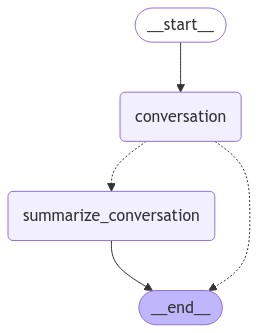

In [25]:
# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is a summary, then we add it
    if summary:

        # Add summary to system messages
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summaryize the conversation
def should_continue(state: State):

    """ Return the next node to execute. """

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

workflow = StateGraph(State)

workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [30]:
# Create a thread
config = {"configurabe": {"thread_id": "1"}}

#reply = graph.invoke({"messages": [HumanMessage(content="Hi! I am Lance")]}, config=config)

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm Lance")]}, config=config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 11, 'total_tokens': 22, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_703d4ff298', 'finish_reason': 'stop', 'logprobs': None}, id='run-1819db4c-7ee0-4337-946c-91d0d8fcc543-0', usage_metadata={'input_tokens': 11, 'output_tokens': 11, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [38]:
for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm Lance")]},config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?


In [ ]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?


In [39]:
# Get a new thread for the conversation
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="Hi! I am Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Hi! I am Lance
---------------------------------------------------------------------------
================================ Human Message =================================

Hi! I am Lance
================================== Ai Message ==================================

Hello, Lance! How can I assist you today?
---------------------------------------------------------------------------


### Streaming tokens

We can stream back tokens using the `.astream_events` method, which stream back events as they happen inside nodes!

Each event is a dict with a few keys:
* `event`: Type of emitted event
* `name`: This is the name of the event
* `data`: This is the data associated with the event.
* `metadata`: Contains `langgraph_node`, the node emitting the event

In [41]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: 

In [42]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens for a particular node
    if event["event"] == "on_chat_model_stream" and event["metadata"].get('langgraph_node', "") == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-527263c2-7443-4eda-86d5-e7a561cb5b72')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run-527263c2-7443-4eda-86d5-e7a561cb5b72')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run-527263c2-7443-4eda-86d5-e7a561cb5b72')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run-527263c2-7443-4eda-86d5-e7a561cb5b72')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run-527263c2-7443-4eda-86d5-e7a561cb5b72')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run-527263c2-7443-4eda-86d5-e7a561cb5b72')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run-527263c2-7443-4eda-86d5-e7a561cb5b72')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, response_me

In [43]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens for a particular node
    if event["event"] == "on_chat_model_stream" and event["metadata"].get('langgraph_node', "") == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.| They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| club| of| the| league|'s| National| Football| Conference| (|N|FC|)| West| division|.| The| team| was| founded| in| |194|6| as| a| charter| member| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |194|9| when| the| leagues| merged|.

|###| Key| Points| about| the| |49|ers|:

|-| **|St|adium|**|:| The| |49|ers| play| their| home| games| at| Levi|'s| Stadium| in| Santa| Clara|,| California|,| which| they| moved| to| in| |201|4|.| Before| that|,| they| played| at| Cand|lestick| Park| in| San| Francisco|.

|-| **|Team| Colors|**|:| The| team's| colors| are| red|,| gold|,| and| white|.

|-| **|Champ|ionship|s|**|:| The| |49|ers| have| won| five| Super| Bowl| titles| (|X|VI|,| XIX|,| XX|III|,| XX|IV|,| and| XX|IX|),| with| their| most| successful| period| being

80902.25